In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import mylib
from mylib.dataloading import *
from mylib import utilities
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from functools import reduce
from sklearn.decomposition import PCA
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
plt.style.use('seaborn')
params = {
    'figure.figsize': (15, 5),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

In [5]:
df = load_customer_data(PREPROCESSED_DATASET_NAME)

# Clean the dataset

We start the cleaning of the dataset by removing all entries without a CustomerID since we can't use them for extracting the indicators due to the fact that we cannot discern the different Customers behind that ID.

In [6]:
noid_customer = df[df['CustomerID'] == 0].index
# Delete these row indexes from dataFrame
df.drop(noid_customer, inplace=True)

In [7]:
print("# of entries with negative sale %d" % df.query("Sale < 0").shape[0]) 

# of entries with negative sale 0


There are no more entries with negative sale. It means that all entries with negative sale were associated with a null **CustomerID**.

We remove some outliers from the two numerical attributes, Qta and Sale, by discarding the elements $e$ such that 
$$e \lt \epsilon \cdot \text{q1 and } e > \epsilon \cdot \text{q3}$$

In [8]:
df = utilities.get_subset_by_IQR(df, "Qta")

In [9]:
df = utilities.get_subset_by_IQR(df, "Sale")

In [10]:
save_customer_dataset(df, CLEAN_DATASET_NAME)

dataset saved to /home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/datasets/customer/customer_supermarket_clean.csv


## Add informative attributes

The next step is to compute and add a column for the **Revenue**, it will be useful for computing the indicator for the monetary value.

In [11]:
df["Revenue"] = df["Qta"] * df["Sale"]

In [12]:
df_date = pd.DataFrame(df[["BasketDate", "Revenue"]])
df_date['BasketYear'] = df_date['BasketDate'].dt.year
df_date['BasketMonth'] = df_date['BasketDate'].dt.month
df_date['BasketDay'] = df_date['BasketDate'].dt.day
df_date['BasketDayName'] = df_date['BasketDate'].dt.day_name()

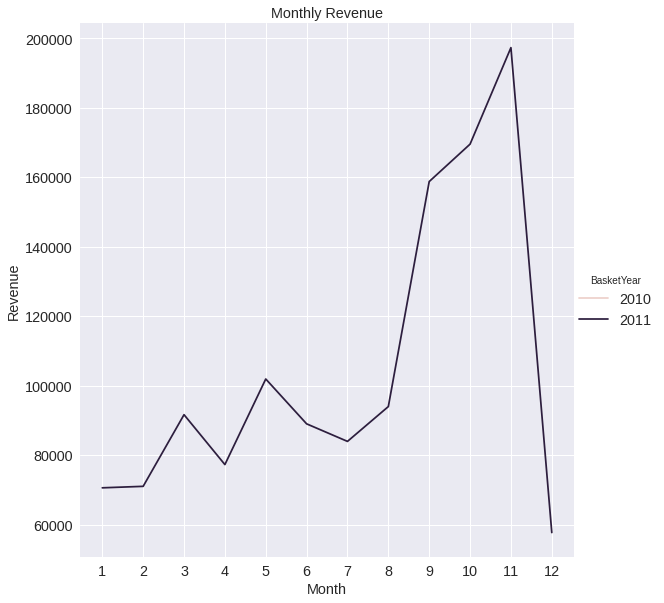

In [13]:
df_revenue = df_date.groupby(["BasketYear", "BasketMonth"])["Revenue"].sum().reset_index()
sns.relplot(x="BasketMonth", y="Revenue", hue="BasketYear", kind="line", data=df_revenue, height=8)
plt.title("Monthly Revenue")
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

The plot above shows montly revenue of the supermarket. In December the revenue value plummet due to the fact that the observations end at the beginning of the month.

## Extract useful indicator for customer segmentation

### The following indicators are the mandatory ones required by the assignment
They are computed with simple manipulations of the dataframe.

### Total number of items purchased by a customer during the period of observation.

In [14]:
tot_items = df.groupby('CustomerID')['Qta'].sum().reset_index()
tot_items.columns = ['CustomerID', 'I']
display(tot_items.head())

,CustomerID,I
0,12347,542
1,12349,124
2,12350,54
3,12352,131
4,12353,6


### Number of distinct items purchased by a customer during the period of observation.

In [15]:
dist_items = df.groupby('CustomerID')['ProdID'].nunique().reset_index()
dist_items.columns = ['CustomerID', 'Iu']
display(dist_items.head())

,CustomerID,Iu
0,12347,43
1,12349,19
2,12350,5
3,12352,17
4,12353,1


### Maximum number of items purchased by a customer during a shopping session

In [16]:
max_nitems = df.groupby(["CustomerID", "BasketID"]).Qta.sum().max(level='CustomerID').reset_index()
max_nitems.columns = ["CustomerID", "Imax"]
display(max_nitems.head())

,CustomerID,Imax
0,12347,200
1,12349,124
2,12350,54
3,12352,35
4,12353,6


### Shannon entropy on the purchasing behavior of the customer
We computed the entropy on the different products the customer had bought during the period of observation

In [17]:
entr = df.groupby(by=[ 'CustomerID'])['ProdID'].apply(lambda x : entropy(x.value_counts(), base=2)).reset_index()
entr.columns = ['CustomerID', 'E']
display(entr.head())

,CustomerID,E
0,12347,5.176319
1,12349,4.247928
2,12350,2.321928
3,12352,3.936180
4,12353,0.000000


## Additional indicators

In this section we extract some useful indicators that will be useful for the customer segmentation. We start by computing the Recency, Frequency and Monetary Value indicators (RFM). This indicators are a useful way to evaluate the customers not as much in function of their propensity to buy but rather in terms of "turnover potential".

In [18]:
df_user = pd.DataFrame(df["CustomerID"].unique())
df_user.columns = ["CustomerID"]

### Recency

Recency gives us an indication about how recently customers make a purchase. We gathered by _CustomerID_ and we computed the recency.

In [19]:
last_date = df["BasketDate"].max()

In [20]:
# Recency Calculation
df_last_purchase = df.groupby(["CustomerID"])["BasketDate"].max().reset_index()
df_last_purchase.columns = ["CustomerID", "LastPurchaseDate"]
df_last_purchase["Recency"] = (last_date - df_last_purchase["LastPurchaseDate"]).dt.days
df_recency = pd.merge(df_user, df_last_purchase[["CustomerID", "Recency"]])
display(df_recency.head())

,CustomerID,Recency
0,17850,371
1,13047,56
2,12583,2
3,14688,7
4,15311,2


The following plot shows the distribution of the Recency indicator.

Text(0, 0.5, 'Customer Count')

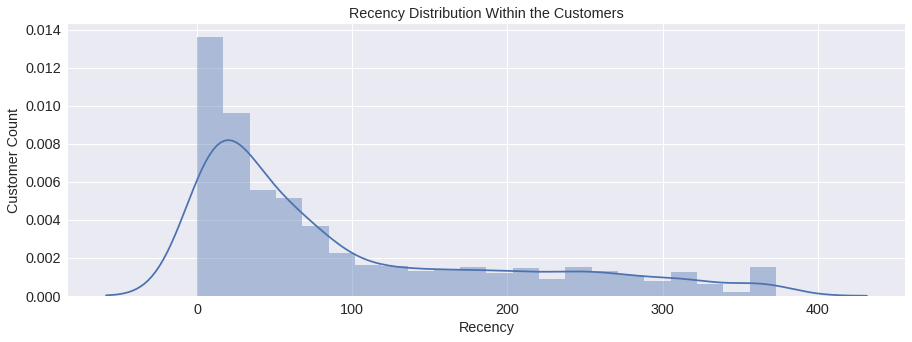

In [21]:
# Look at the distribution of Recency
sns.distplot(df_recency["Recency"])
plt.title("Recency Distribution Within the Customers")
plt.xlabel("Recency")
plt.ylabel("Customer Count")

### Frequency

Frequency measures how often customers purchase. Therefore in the following we segment customers by relying on frequency value.

In [22]:
# Frequency Calculations
df_frequency = df.groupby(["CustomerID"])["BasketDate"].nunique().reset_index()
df_frequency.columns=["CustomerID", "Frequency"]
df_frequency = pd.merge(df_user, df_frequency, on="CustomerID")
display(df_frequency.head())

,CustomerID,Frequency
0,17850,17
1,13047,7
2,12583,15
3,14688,16
4,15311,49


In [23]:
print("Largest values of frequency")
display(df_frequency.nlargest(5, 'Frequency'))
print("Smallest values of frequency")
display(df_frequency.nsmallest(5, 'Frequency'))

Largest values of frequency


,CustomerID,Frequency
49,14911,178
52,17841,85
267,13089,63
194,12748,58
4,15311,49


Smallest values of frequency


,CustomerID,Frequency
6,18074,1
18,17908,1
22,16583,1
27,17968,1
33,14729,1


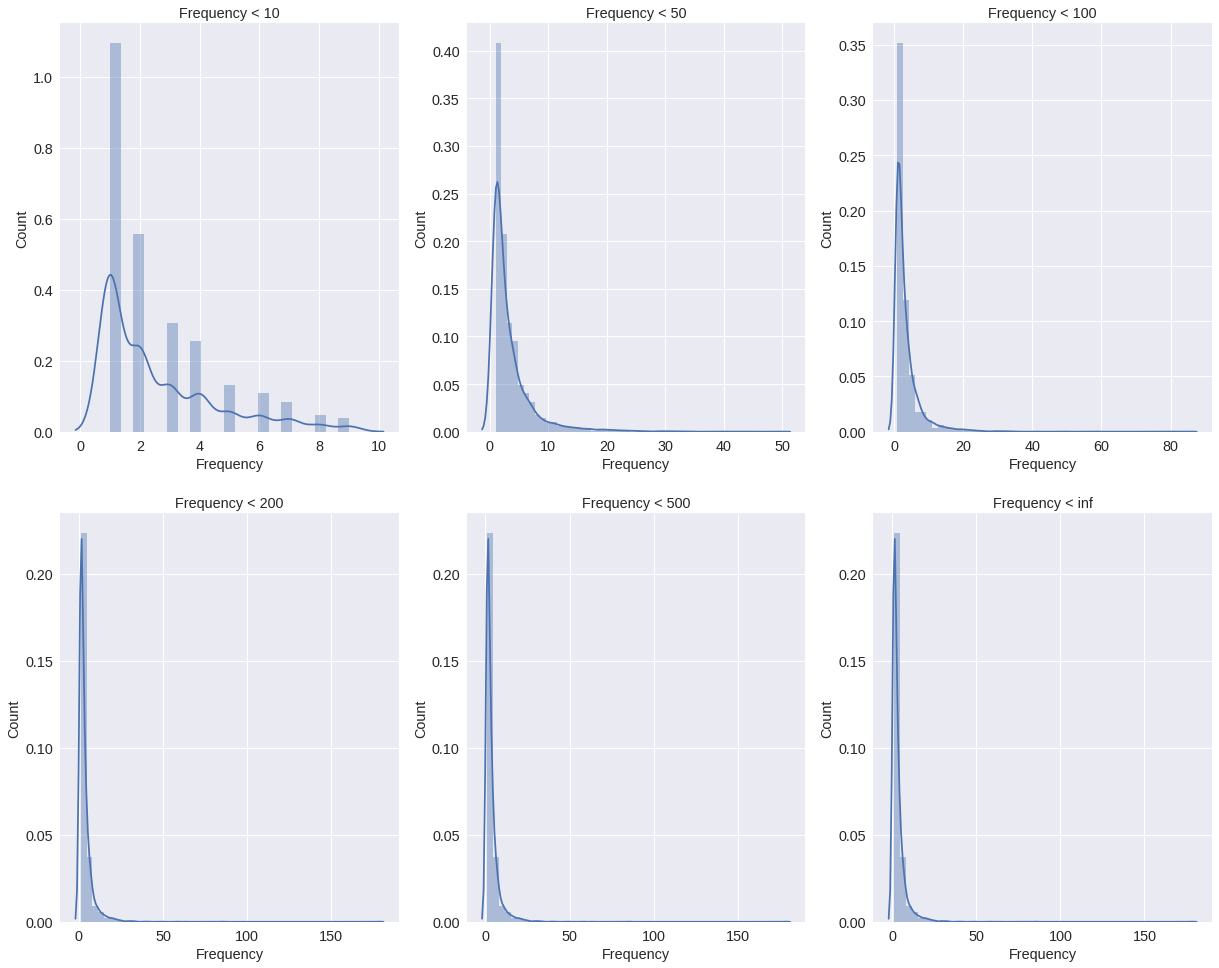

In [24]:
n_plots = 6
n_rows = 2
n_columns = 3
limits = [10, 50, 100, 200, 500, np.inf]
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 16))
plt.subplots_adjust(bottom = 0.1, left=0.1)
for ax, limit in zip(axes.flatten(), limits):
    # Look at the distribution of Frequency with a value < 1000
    sns.distplot(df_frequency[df_frequency["Frequency"] < limit]["Frequency"], ax=ax)
    ax.set_title("Frequency < " + str(limit))
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Count")
plt.show()

There are a lot of customers that have a small frequency value. We defined a list of limits in order to understand how the distribution change w.r.t increasing limits.

### Monetary Value

Monetary Value shows how much do the customers spend.

In [25]:
# Look at the distribution of the Monetary Value
df_monetary_value = df.groupby(["CustomerID"])["Revenue"].sum().reset_index()
df_monetary_value.columns = ['CustomerID', 'MonetaryValue']
df_monetary_value = pd.merge(df_user, df_monetary_value, on="CustomerID")
display(df_monetary_value.head())

,CustomerID,MonetaryValue
0,17850,2627.74
1,13047,1202.98
2,12583,1748.72
3,14688,875.90
4,15311,1408.67


In [26]:
print("Largest values of monetary value")
display(df_monetary_value.nlargest(5, 'MonetaryValue'))
print("Smallest values of monetary value")
display(df_monetary_value.nsmallest(5, 'MonetaryValue'))

Largest values of monetary value


,CustomerID,MonetaryValue
49,14911,31539.17
2899,14096,11167.17
267,13089,10218.41
534,14298,5281.16
304,17675,5210.11


Smallest values of monetary value


,CustomerID,MonetaryValue
1070,14549,7.8
2497,16498,7.8
3263,17201,7.8
3423,14995,7.8
3509,17038,7.8


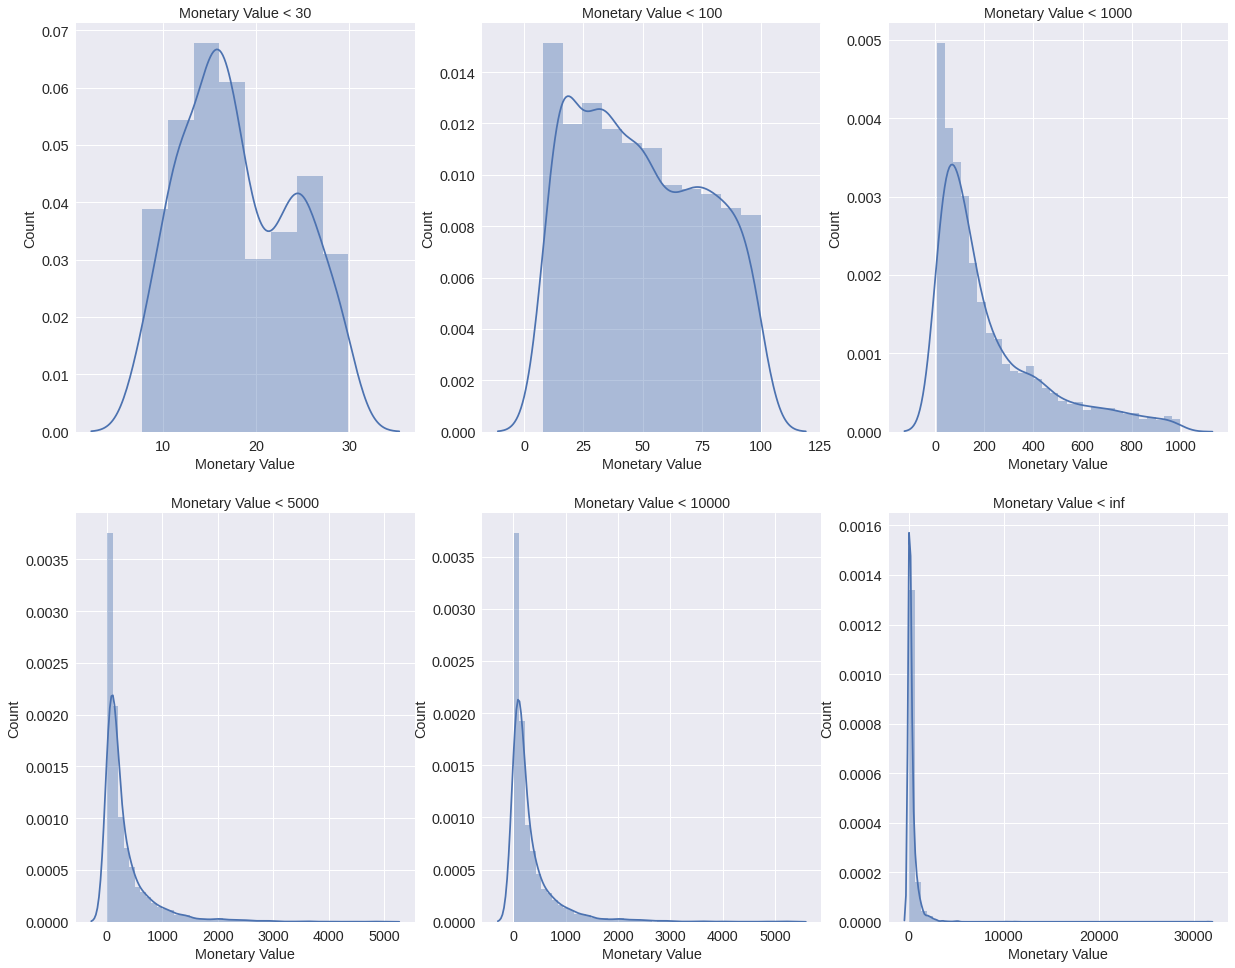

In [27]:
n_plots = 6
n_rows = 2
n_columns = 3
limits = [30, 100, 1000, 5000, 10000, np.inf]
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 16))
plt.subplots_adjust(bottom = 0.1, left=0.1)
for ax, limit in zip(axes.flatten(), limits):
    # Look at the distribution of Frequency with a value < 1000
    sns.distplot(df_monetary_value[df_monetary_value["MonetaryValue"] < limit]["MonetaryValue"], ax=ax)
    ax.set_title("Monetary Value < " + str(limit))
    ax.set_xlabel("Monetary Value")
    ax.set_ylabel("Count")
plt.show()

The same considerations of the plot of the Frequency apply here.

### Days from the first purchase

In [28]:
# FirstPurchase Calculation
df_purchase = df.groupby(["CustomerID"])["BasketDate"].min().reset_index()
df_purchase.columns = ["CustomerID", "FirstPurchaseDate"]
df_purchase["FirstPurchase"] = (last_date - df_purchase["FirstPurchaseDate"]).dt.days
df_first_purchase = pd.merge(df_user, df_purchase[["CustomerID", "FirstPurchase"]])
display(df_first_purchase.head())

,CustomerID,FirstPurchase
0,17850,373
1,13047,373
2,12583,373
3,14688,373
4,15311,373


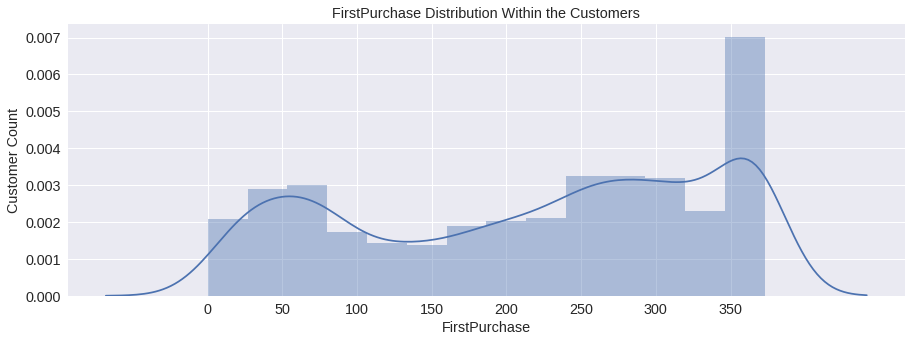

In [29]:
sns.distplot(df_first_purchase["FirstPurchase"])
plt.title("FirstPurchase Distribution Within the Customers")
plt.xticks(range(0, 400, 50))
plt.xlabel("FirstPurchase")
plt.ylabel("Customer Count")
plt.show()

### Minimum number of items purchased by a customer during a shopping session

In [30]:
min_nitems = df.groupby(["CustomerID", "BasketID"]).Qta.sum().min(level='CustomerID').reset_index()
min_nitems.columns = ["CustomerID", "Imin"]
display(min_nitems.head())

,CustomerID,Imin
0,12347,18
1,12349,124
2,12350,54
3,12352,12
4,12353,6


### Most Bought Product per customer

In [31]:
mbp = df.groupby(["CustomerID", "ProdID"])['Qta'].sum().max(level=['CustomerID','ProdID']).reset_index().sort_values(["CustomerID", "Qta"], ascending=False).drop_duplicates(["CustomerID"]).sort_values("CustomerID")
mbp = mbp[["CustomerID", "ProdID"]].reset_index(drop=True)
mbp.columns = ["CustomerID", "MBP"]
display(mbp.head())

,CustomerID,MBP
0,12347,22727
1,12349,23439
2,12350,20615
3,12352,22413
4,12353,37450


### Country origin
We saved also the country of the customer, even though it isn't a numerical attribute it may be useful if at some point one decides to segment the british customers separately from the others.

In [32]:
country = df.groupby('CustomerID')['CustomerCountry'].unique().reset_index()
country.columns = ['CustomerID', 'Country']
display(country.head())

,CustomerID,Country
0,12347,[Iceland]
1,12349,[Italy]
2,12350,[Norway]
3,12352,[Norway]
4,12353,[Bahrain]


## Merging the indicators, exploring the new customer profile and saving it to a file.

We merge all the computed indicators into a new customer_profile dataframe.

In [33]:
indicators = [country, tot_items, dist_items, max_nitems, min_nitems, entr, mbp, df_recency, df_frequency, df_monetary_value, df_first_purchase]
customer_profile = reduce(lambda l, r: pd.merge(l, r, on='CustomerID', how='inner'), indicators).dropna()
display(customer_profile.head())

,CustomerID,Country,I,Iu,Imax,Imin,E,MBP,Recency,Frequency,MonetaryValue,FirstPurchase
0,12347,[Iceland],542,43,200,18,5.176319,22727,1,7,1742.36,366
1,12349,[Italy],124,19,124,124,4.247928,23439,18,1,345.92,18
2,12350,[Norway],54,5,54,54,2.321928,20615,309,1,118.50,309
3,12352,[Norway],131,17,35,12,3.936180,22413,35,6,395.83,296
4,12353,[Bahrain],6,1,6,6,0.000000,37450,203,1,17.70,203


# Exploration and (pre) processing of the newly computed indicators
We start by isolating the numerical values from the others.

In [34]:
numerical_customer_profile = customer_profile.loc[:, customer_profile.columns != 'CustomerID']
numerical_customer_profile = numerical_customer_profile.loc[:, numerical_customer_profile.columns != 'Country']
numerical_customer_profile = numerical_customer_profile.loc[:, numerical_customer_profile.columns != 'MBP']

In [35]:
len(numerical_customer_profile) == len(customer_profile)

True

In [36]:
display(numerical_customer_profile.describe())

,I,Iu,Imax,Imin,E,Recency,Frequency,MonetaryValue,FirstPurchase
count,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000
mean,132.709987,13.226365,51.253529,23.680692,2.830787,95.232224,3.475899,360.700644,216.711318
std,278.111739,18.022463,49.207314,29.345671,1.562269,101.348951,5.230911,768.993563,117.967272
min,4.000000,1.000000,4.000000,4.000000,0.000000,0.000000,1.000000,7.800000,0.000000
25%,24.000000,3.000000,18.000000,6.000000,1.584963,18.000000,1.000000,68.395000,99.000000
50%,57.000000,8.000000,38.000000,14.000000,2.807355,52.000000,2.000000,155.800000,241.000000
75%,148.000000,17.000000,66.000000,30.000000,3.997340,151.000000,4.000000,403.345000,319.000000
max,10996.000000,565.000000,557.000000,534.000000,8.560848,373.000000,178.000000,31539.170000,373.000000


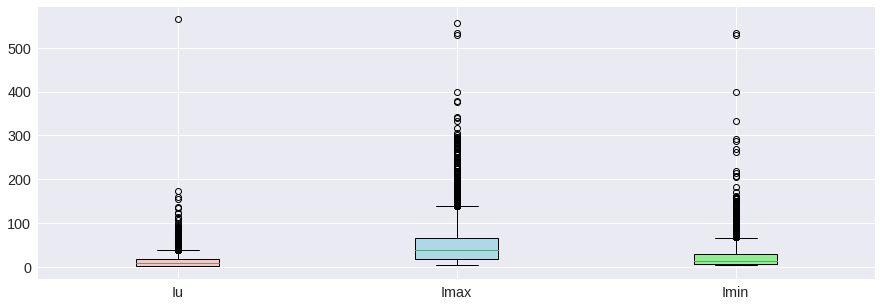

In [37]:
labels = ["Iu", "Imax", "Imin"]
bplot1 = plt.boxplot(
    numerical_customer_profile[labels],
    vert=True,  # vertical box alignment
    patch_artist=True,  # fill with color
    labels=labels  # will be used to label x-ticks
)
# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

<AxesSubplot:>

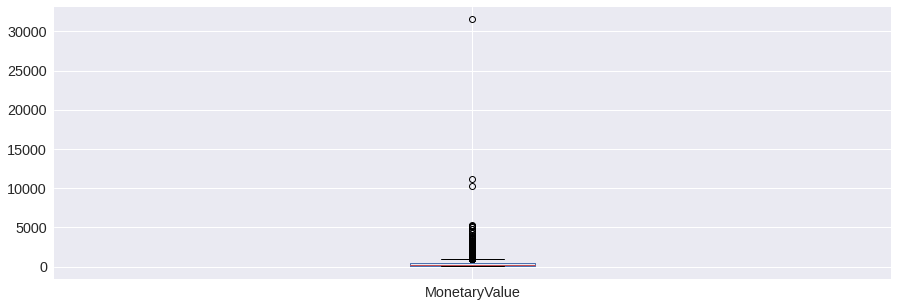

In [38]:
numerical_customer_profile.boxplot(column="MonetaryValue")

In [39]:
idx_drop_mv = numerical_customer_profile[numerical_customer_profile["MonetaryValue"] > 10000].index
numerical_customer_profile.drop(idx_drop_mv, inplace=True)

<AxesSubplot:>

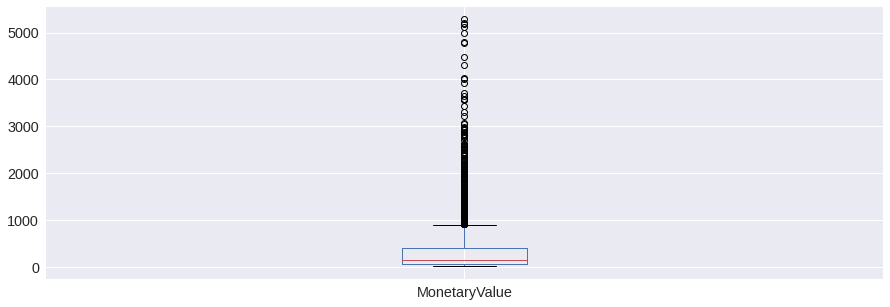

In [40]:
numerical_customer_profile.boxplot(column="MonetaryValue")

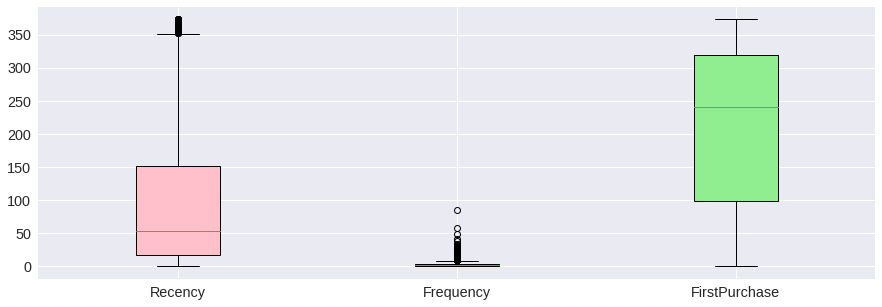

In [41]:
labels = ["Recency", "Frequency", "FirstPurchase"]
bplot2 = plt.boxplot(
    numerical_customer_profile[labels],
    vert=True,  # vertical box alignment
    patch_artist=True,  # fill with color
    labels=labels  # will be used to label x-ticks
)
# fill with colors
colors = ['pink', 'lightblue', 'lightgreen', 'orange']
for patch, color in zip(bplot2['boxes'], colors):
    patch.set_facecolor(color)

In [42]:
customer_profile.drop(idx_drop_mv, inplace=True)

In [43]:
len(numerical_customer_profile) == len(customer_profile)

True

The following matrix shows the correlation between the computed indicators.

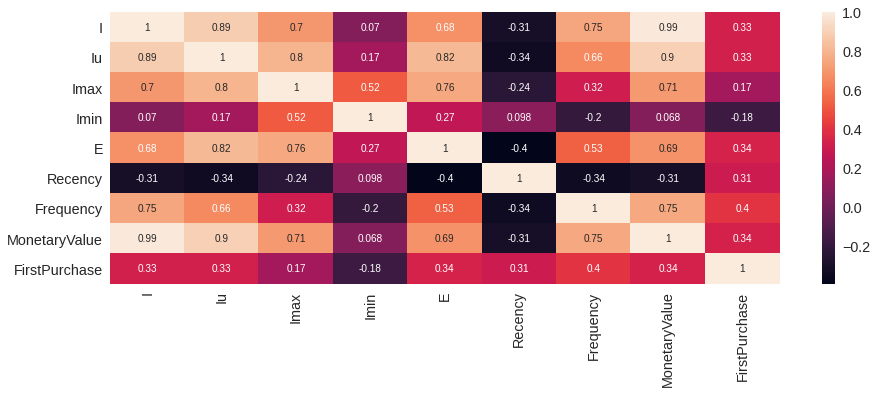

In [44]:
corrMatrix = numerical_customer_profile.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

The following plot shows the pairwise relationships between the attributes.
The diagonal plots are treated differently. Instead of plotting a straight line a univariate distribution plot is drawn to show the marginal distribution of the data in each column.

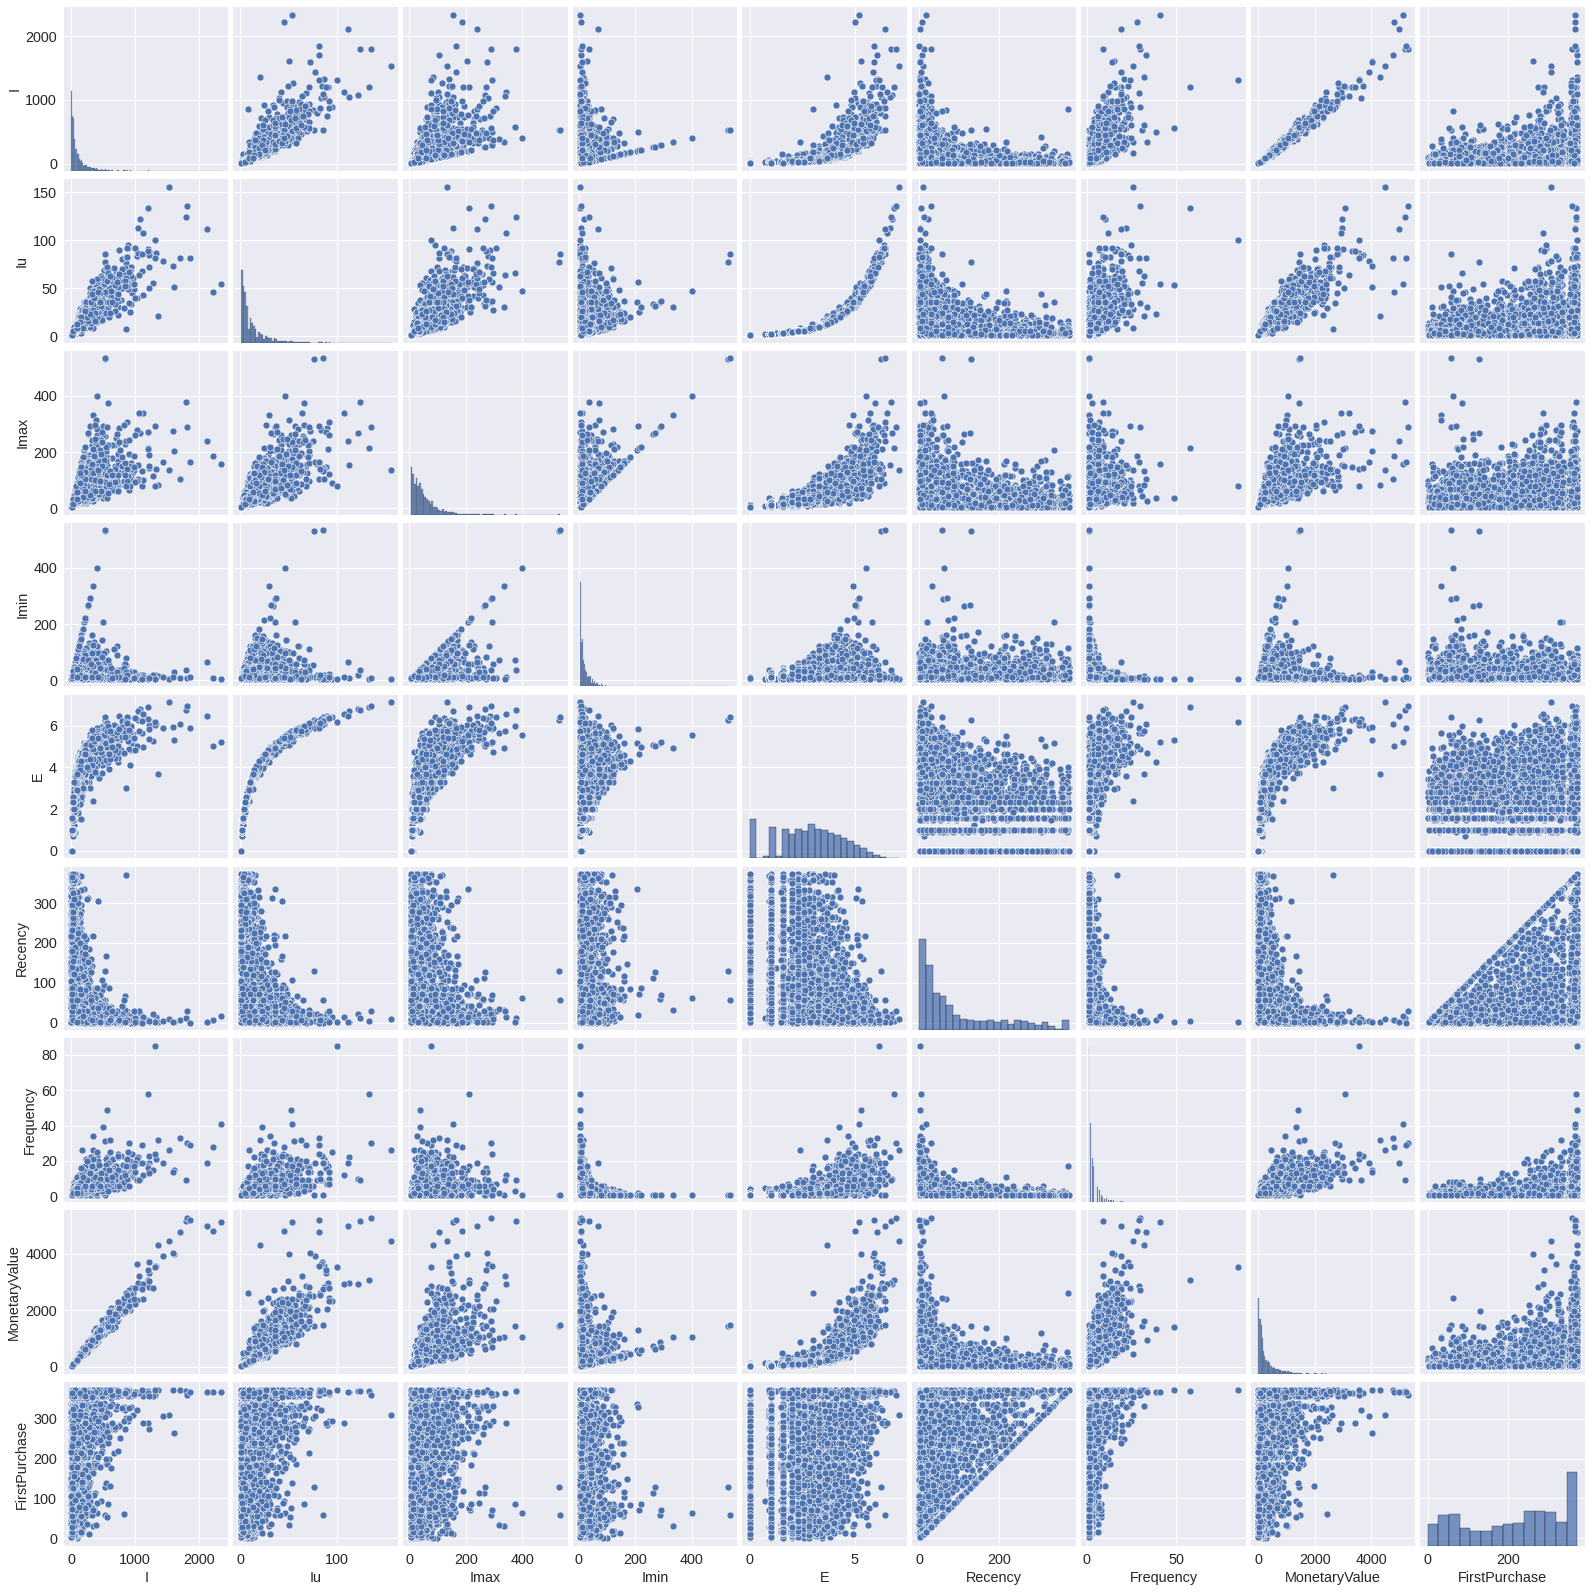

In [45]:
sns.pairplot(numerical_customer_profile)
plt.show()

In [46]:
save_customer_dataset(customer_profile, CUSTOMER_PROFILE_DATASET_NAME)

dataset saved to /home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/datasets/customer/customer_profile.csv
